In [108]:
#imports and settings
import pandas as pd 
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('fivethirtyeight')
import seaborn as sns
from patsy import dmatrices

%pylab inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Populating the interactive namespace from numpy and matplotlib


In [109]:
file1 = "../data/processed/loan_known_data.csv"

ChunkSize = 100000
i = 1
for chunk in pd.read_csv(file1, chunksize=ChunkSize, low_memory=False):
    data = chunk if i == 1 else pd.concat([data, chunk])
    print('-->Read Chunk...', i)
    i += 1


-->Read Chunk... 1
-->Read Chunk... 2
-->Read Chunk... 3
-->Read Chunk... 4
-->Read Chunk... 5


In [110]:
df_sample = data.copy()
df_sample['loan_status'].value_counts()

Good loans    340524
Bad loans      93443
Name: loan_status, dtype: int64

In [111]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Good loans':
        return 0
    else:
        return 1
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

0    340524
1     93443
Name: Late_Loan, dtype: int64

In [112]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)/10
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['loan_status','verification_status','percent_complete',
                            'max_bal_bc_cat', 'num_sats_cat', 'percent_bc_gt_75_cat'],axis =1)


In [113]:
df_sample.head()

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,initial_list_status,open_acc_6m,open_act_il,open_il_12m,il_util,open_rv_12m,inq_fi,inq_last_12m,acc_open_past_24mths,mort_acc,num_accts_ever_120_pd,num_tl_op_past_12m,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,year,Late_Loan
0,8400,36 months,10.75,274.02,B,Administrative Assistant,4,RENT,49999.0,debt_consolidation,NY,4.61,0.0,f,0.0,1.0,0.0,78.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,77000.0,63633.0,9900.0,2016,1
1,6000,36 months,17.27,214.73,D,Teacher,10,OWN,72000.0,home_improvement,MI,22.80,0.0,w,2.0,2.0,0.0,32.0,2.0,0.0,4.0,5.0,0.0,0.0,2.0,53296.0,30256.0,15800.0,2016,0
2,12000,36 months,11.55,396.00,B,ucsf,1,RENT,120000.0,debt_consolidation,CA,5.75,0.0,f,0.0,1.0,0.0,78.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,34419.0,18628.0,7181.0,2013,0
3,4000,36 months,14.49,137.67,C,Barista,9,RENT,33000.0,debt_consolidation,AK,34.57,0.0,f,2.0,3.0,2.0,66.0,2.0,1.0,4.0,5.0,0.0,0.0,4.0,48247.0,30408.0,14200.0,2016,1
4,2000,36 months,14.16,68.52,C,Meter Reader,5,MORTGAGE,33000.0,major_purchase,IL,19.74,2.0,w,0.0,1.0,0.0,78.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,89433.0,16574.0,12200.0,2014,0


In [114]:
df_sample.shape

(433967, 30)

In [115]:
cor_mat = df_sample.corr().abs()
cor_mat.style.background_gradient(cmap='coolwarm')

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,open_acc_6m,open_act_il,open_il_12m,il_util,open_rv_12m,inq_fi,inq_last_12m,acc_open_past_24mths,mort_acc,num_accts_ever_120_pd,num_tl_op_past_12m,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,year,Late_Loan
loan_amnt,1.000000,0.147981,0.951819,0.081538,0.267908,0.019557,0.009291,0.016361,0.018774,0.009118,0.051367,0.024903,0.004183,0.001695,0.002871,0.227284,0.060867,0.030381,0.322047,0.257536,0.363254,0.004152,0.078506
int_rate,0.147981,1.000000,0.158407,0.008875,0.066967,0.177880,0.045261,0.105695,0.052072,0.127956,0.087625,0.090464,0.103738,0.115266,0.194636,0.092100,0.060946,0.210508,0.113872,0.011325,0.224862,0.017966,0.268465
installment,0.951819,0.158407,1.000000,0.069156,0.260656,0.023495,0.000519,0.001080,0.026725,0.006907,0.049703,0.003988,0.017533,0.019650,0.010275,0.191374,0.048830,0.009913,0.290653,0.244107,0.331059,0.005313,0.061464
emp_length,0.081538,0.008875,0.069156,1.000000,0.057525,0.016599,0.019111,0.000437,0.055479,0.005904,0.057798,0.008212,0.003440,0.014096,0.017027,0.214080,0.023058,0.019614,0.113998,0.025099,0.062906,0.022108,0.020301
annual_inc,0.267908,0.066967,0.260656,0.057525,1.000000,0.161896,0.033060,0.033083,0.064152,0.054023,0.034063,0.011976,0.047535,0.048305,0.044272,0.187938,0.018004,0.041301,0.354220,0.266432,0.235866,0.032797,0.034483
dti,0.019557,0.177880,0.023495,0.016599,0.161896,1.000000,0.018640,0.026419,0.201647,0.100691,0.027829,0.005655,0.053284,0.026841,0.143470,0.042585,0.060961,0.081434,0.006333,0.261740,0.027268,0.033435,0.103668
delinq_2yrs,0.009291,0.045261,0.000519,0.019111,0.033060,0.018640,1.000000,0.001228,0.032893,0.008763,0.007905,0.013101,0.009035,0.012914,0.070650,0.076078,0.209214,0.039161,0.057785,0.028623,0.078428,0.007813,0.021689
open_acc_6m,0.016361,0.105695,0.001080,0.000437,0.033083,0.026419,0.001228,1.000000,0.421774,0.589282,0.017107,0.741892,0.452814,0.611914,0.321140,0.001525,0.053524,0.417087,0.062627,0.070695,0.051296,0.485021,0.078086
open_act_il,0.018774,0.052072,0.026725,0.055479,0.064152,0.201647,0.032893,0.421774,1.000000,0.557988,0.019133,0.365918,0.419874,0.466894,0.168721,0.019795,0.047516,0.133220,0.111851,0.285202,0.022054,0.465020,0.063014
open_il_12m,0.009118,0.127956,0.006907,0.005904,0.054023,0.100691,0.008763,0.589282,0.557988,1.000000,0.142178,0.402467,0.504784,0.587794,0.282508,0.007243,0.035086,0.361655,0.074133,0.151765,0.011107,0.451810,0.068588


In [116]:
upper = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))

In [117]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [118]:
df_sample = df_sample.drop(to_drop, axis=1)

In [119]:
df_sample = df_sample.drop(['year', 'total_bal_ex_mort'], axis=1)

In [120]:
cor_mat = df_sample.corr().abs()
cor_mat.style.background_gradient(cmap='coolwarm')

,loan_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,open_acc_6m,open_act_il,open_il_12m,il_util,open_rv_12m,inq_fi,inq_last_12m,acc_open_past_24mths,mort_acc,num_accts_ever_120_pd,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,Late_Loan
loan_amnt,1.000000,0.147981,0.081538,0.267908,0.019557,0.009291,0.016361,0.018774,0.009118,0.051367,0.024903,0.004183,0.001695,0.002871,0.227284,0.060867,0.030381,0.322047,0.363254,0.078506
int_rate,0.147981,1.000000,0.008875,0.066967,0.177880,0.045261,0.105695,0.052072,0.127956,0.087625,0.090464,0.103738,0.115266,0.194636,0.092100,0.060946,0.210508,0.113872,0.224862,0.268465
emp_length,0.081538,0.008875,1.000000,0.057525,0.016599,0.019111,0.000437,0.055479,0.005904,0.057798,0.008212,0.003440,0.014096,0.017027,0.214080,0.023058,0.019614,0.113998,0.062906,0.020301
annual_inc,0.267908,0.066967,0.057525,1.000000,0.161896,0.033060,0.033083,0.064152,0.054023,0.034063,0.011976,0.047535,0.048305,0.044272,0.187938,0.018004,0.041301,0.354220,0.235866,0.034483
dti,0.019557,0.177880,0.016599,0.161896,1.000000,0.018640,0.026419,0.201647,0.100691,0.027829,0.005655,0.053284,0.026841,0.143470,0.042585,0.060961,0.081434,0.006333,0.027268,0.103668
delinq_2yrs,0.009291,0.045261,0.019111,0.033060,0.018640,1.000000,0.001228,0.032893,0.008763,0.007905,0.013101,0.009035,0.012914,0.070650,0.076078,0.209214,0.039161,0.057785,0.078428,0.021689
open_acc_6m,0.016361,0.105695,0.000437,0.033083,0.026419,0.001228,1.000000,0.421774,0.589282,0.017107,0.741892,0.452814,0.611914,0.321140,0.001525,0.053524,0.417087,0.062627,0.051296,0.078086
open_act_il,0.018774,0.052072,0.055479,0.064152,0.201647,0.032893,0.421774,1.000000,0.557988,0.019133,0.365918,0.419874,0.466894,0.168721,0.019795,0.047516,0.133220,0.111851,0.022054,0.063014
open_il_12m,0.009118,0.127956,0.005904,0.054023,0.100691,0.008763,0.589282,0.557988,1.000000,0.142178,0.402467,0.504784,0.587794,0.282508,0.007243,0.035086,0.361655,0.074133,0.011107,0.068588
il_util,0.051367,0.087625,0.057798,0.034063,0.027829,0.007905,0.017107,0.019133,0.142178,1.000000,0.076792,0.003210,0.023233,0.108459,0.021810,0.044386,0.125209,0.019242,0.068289,0.012342


In [121]:
df_sample.shape

(433967, 27)

In [122]:
df_sample.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'initial_list_status', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'il_util', 'open_rv_12m', 'inq_fi', 'inq_last_12m',
       'acc_open_past_24mths', 'mort_acc', 'num_accts_ever_120_pd',
       'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit', 'Late_Loan'],
      dtype='object')

In [123]:
df_sample['delinq_2yrs'].value_counts()

0.0     347558
1.0      57116
2.0      17072
3.0       6149
4.0       2723
5.0       1438
6.0        750
7.0        423
8.0        238
9.0        154
10.0       122
11.0        59
12.0        47
14.0        29
13.0        28
15.0        21
16.0         9
18.0         7
17.0         7
19.0         6
20.0         4
21.0         3
29.0         1
39.0         1
25.0         1
26.0         1
Name: delinq_2yrs, dtype: int64

In [124]:
df_sample.describe()

,loan_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,open_acc_6m,open_act_il,open_il_12m,il_util,open_rv_12m,inq_fi,inq_last_12m,acc_open_past_24mths,mort_acc,num_accts_ever_120_pd,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,Late_Loan
count,433967.000000,433967.000000,433967.000000,4.339670e+05,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,433967.000000,4.339670e+05,4.339670e+05,433967.000000
mean,14869.012390,13.282221,5.998537,7.870385e+04,18.559836,0.329110,0.399544,1.584851,0.316192,75.820304,0.497135,0.399090,0.762210,4.396297,1.476057,0.422168,2.072425,1.799787e+05,2.200151e+04,0.215323
std,8792.834883,4.829201,3.695492,7.857993e+04,9.263519,0.891994,0.804034,1.217722,0.690909,13.740272,0.922878,0.847717,1.326249,2.389079,1.510722,0.850716,1.523645,1.776527e+05,2.138128e+04,0.411047
min,1000.000000,5.310000,0.000000,1.000000e+02,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+02,1.000000e+02,0.000000
25%,8000.000000,9.750000,3.000000,4.854350e+04,12.230000,0.000000,0.000000,1.000000,0.000000,78.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,5.350000e+04,8.100000e+03,0.000000
50%,13000.000000,12.740000,6.000000,6.690000e+04,17.930000,0.000000,0.000000,1.000000,0.000000,78.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,2.000000,1.202120e+05,1.550000e+04,0.000000
75%,20000.000000,16.020000,10.000000,9.400000e+04,24.330000,0.000000,0.000000,2.000000,0.000000,78.000000,1.000000,0.000000,1.000000,6.000000,3.000000,0.000000,3.000000,2.590745e+05,2.860000e+04,0.000000
max,40000.000000,30.990000,10.000000,1.099920e+07,999.000000,39.000000,3.000000,5.000000,3.000000,464.000000,3.000000,3.000000,4.000000,8.000000,4.000000,3.000000,5.000000,9.999999e+06,1.105500e+06,1.000000


In [125]:
Q1 = df_sample.quantile(0.05)
Q3 = df_sample.quantile(0.95)
IQR = Q3 - Q1

df_filtered = df_sample[~((df_sample < (Q1 - 1.0 * IQR)) |(df_sample > (Q3 + 1.0 * IQR))).any(axis=1)]

In [126]:
df_sample.shape

(433967, 27)

In [127]:
df_filtered.shape

(424197, 27)

In [132]:
df_filtered.describe()

,loan_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,open_acc_6m,open_act_il,open_il_12m,il_util,open_rv_12m,inq_fi,inq_last_12m,acc_open_past_24mths,mort_acc,num_accts_ever_120_pd,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,Late_Loan
count,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000,424197.000000
mean,14734.517924,13.302217,5.993479,75157.895817,18.558493,0.279542,0.396429,1.576584,0.313519,75.791057,0.494940,0.395288,0.755104,4.397542,1.458450,0.414961,2.070514,172681.842939,21233.735017,0.215815
std,8692.369758,4.821935,3.694345,39068.126816,8.388869,0.664529,0.801012,1.209392,0.687814,13.496084,0.921194,0.843980,1.320754,2.386575,1.504961,0.841695,1.521637,155225.568117,18979.561682,0.411387
min,1000.000000,5.310000,0.000000,2500.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,100.000000,0.000000
25%,8000.000000,9.750000,2.000000,48000.000000,12.330000,0.000000,0.000000,1.000000,0.000000,78.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,52899.000000,8000.000000,0.000000
50%,12750.000000,12.740000,6.000000,65300.000000,18.000000,0.000000,0.000000,1.000000,0.000000,78.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,2.000000,117250.000000,15400.000000,0.000000
75%,20000.000000,16.020000,10.000000,92000.000000,24.380000,0.000000,0.000000,2.000000,0.000000,78.000000,1.000000,0.000000,1.000000,6.000000,3.000000,0.000000,3.000000,253963.000000,28100.000000,0.000000
max,40000.000000,30.990000,10.000000,290000.000000,60.630000,4.000000,3.000000,5.000000,3.000000,141.000000,3.000000,3.000000,4.000000,8.000000,4.000000,3.000000,5.000000,984578.000000,123900.000000,1.000000


In [133]:
cate_cols = ['delinq_2yrs', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'il_util', 'open_rv_12m', 'inq_fi', 
             'inq_last_12m', 'acc_open_past_24mths', 'mort_acc', 'num_accts_ever_120_pd', 'num_tl_op_past_12m']

In [134]:
# for col in cate_cols:
#     df_filtered[col] = df_filtered[col].astype('category')

In [135]:
df_filtered.dtypes

text_columns = list(df_filtered.select_dtypes(include=['object']).columns)


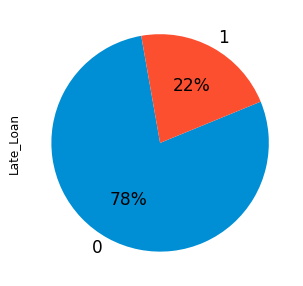

In [136]:
#distribution of our class/targer variable Late_Loan , True if loan is late. 
plt.figure(figsize=(5,5))
df_filtered['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

In [137]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


X = df_filtered.drop('Late_Loan', axis=1)
y = df_filtered['Late_Loan']

sm = SMOTE(random_state=42)

# Y,X = dmatrices('Late_Loan ~ loan_amnt + term + int_rate + grade + emp_title + emp_length + home_ownership + annual_inc + purpose + addr_state + dti + delinq_2yrs + initial_list_status + open_acc_6m + open_act_il + open_il_12m + il_util + open_rv_12m + inq_fi + inq_last_12m + acc_open_past_24mths + mort_acc + num_accts_ever_120_pd + num_tl_op_past_12m + tot_hi_cred_lim + total_bc_limit',df_filtered, return_type = 'dataframe')
# X_columns = X.columns

# sm = SMOTE(random_state=42)
# X, Y = sm.fit_sample(X, Y)
# X = pd.DataFrame(X,columns=X_columns)

# loan_amnt + term + int_rate + grade + emp_title + emp_length + home_ownership + annual_inc + purpose + addr_state + dti + delinq_2yrs + initial_list_status + open_acc_6m + open_act_il + open_il_12m + il_util + open_rv_12m + inq_fi + inq_last_12m + acc_open_past_24mths + mort_acc + num_accts_ever_120_pd + num_tl_op_past_12m + tot_hi_cred_lim + total_bc_limit + Late_Loan


In [138]:
# from collections import Counter
# def normalize_binary(x, y, label):
#  # initial columns list
#     x_columns = x.columns
#     y_column = 'label_column'
#  # get class statistics
#     counter = Counter(y)
#  # get size of minority class
#     label_count = counter[label]
#  # for extremely small classes& apply random oversammpling
#     res_x, res_y = randomSampler.fit_resample(x, y)
#     result_frame = pd.DataFrame(data=res_x, columns=x_columns)
#     result_frame[y_column] = res_y
#  # leave only minority class
#     result_frame = result_frame[result_frame.label_column == label]
#     print(Counter(result_frame['label_column']))
#     return result_frame

In [139]:
# # initial dataframe to which we will append synthetic classes
# # leave only "majority class"
# initial_output = df_filtered[df_filtered.Late_Loan==0]
# # filter out text column
# # initial_output = initial_output.loc[:, initial_output.columns != 'text_column']
# # get list of all classes
# all_labels = set(df_filtered['Late_Loan'])
# all_y = []
# final_featureset = pd.DataFrame()

# for label in all_labels:
#  if label != 0:
#         temp_classes = [label, 0]
#         temp = df_filtered[df_filtered.Late_Loan.isin(temp_classes)]
# #         x = temp.loc[:, temp.columns != text_columns]
#         x = temp.loc[:, temp.columns != 'Late_Loan']
#         y = temp.iloc[:, 0]
#  # get a dataframe with the current class and synthetic samples
#         temp_dataframe = normalize_binary(x, y, label)
#  # add to the initial output
#         initial_output = initial_output.append(temp_dataframe, sort=True)

In [140]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    print ("-"*20," "*5, "ACCUARACY SCORE", " "*5, "-"*20)
    print(" "*10, "Accuracy score for model is : ", round(accuracy_score(test_y, predict_y),4))
    print ("-"*69)
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
    
def print_report(test_y, test_predict):
    from sklearn.metrics import confusion_matrix
    
    
    print(confusion_matrix(test_y, test_predict))

    from sklearn.metrics import classification_report
    print(classification_report(test_y, test_predict))
    
def plot_roc(test_y, test_probs):
    fpr, tpr, threshold = roc_curve(test_y, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [141]:
features = ['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'dti', 'initial_list_status',
            'open_act_il', 'il_util', 'open_rv_12m', 'inq_last_12m', 'acc_open_past_24mths', 'mort_acc',
            'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit', 'Late_Loan']

In [142]:
df_final = df_filtered[features]

In [143]:
df_encode = pd.get_dummies(df_final)

In [144]:
df_encode.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti',
       'open_act_il', 'il_util', 'open_rv_12m', 'inq_last_12m',
       'acc_open_past_24mths', 'mort_acc', 'num_tl_op_past_12m',
       'tot_hi_cred_lim', 'total_bc_limit', 'Late_Loan', 'term_ 36 months',
       'term_ 60 months', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'initial_list_status_f',
       'initial_list_status_w'],
      dtype='object')

In [145]:
df_encode.to_csv("../data/processed/encoded_data.csv", index=False)